## PyTorch MLP for Text Classification - Student Hands-On Notebook (Using Hugging Face Datasets)

In [380]:
 # Install and Import Required Libraries
!pip install torch torchvision datasets --quiet


[notice] A new release of pip is available: 25.0 -> 25.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [381]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns

In [382]:
 #Load Predefined Dataset (AG News)
dataset = load_dataset("ag_news")


In [383]:
dataset

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 120000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 7600
    })
})

In [384]:
#Use a small subset for quick in-class demo
train_data = dataset['train'].shuffle(seed=42).select(range(1000))
test_data = dataset['test'].shuffle(seed=42).select(range(200))

In [385]:
# Convert to DataFrame
df_train = pd.DataFrame(train_data)
df_test = pd.DataFrame(test_data)

In [386]:
df_train

,text,label
0,Bangladesh paralysed by strikes Opposition act...,0
1,Desiring Stability Redskins coach Joe Gibbs ex...,1
2,Will Putin #39;s Power Play Make Russia Safer?...,0
3,U2 pitches for Apple New iTunes ads airing dur...,3
4,S African TV in beheading blunder Public broad...,0
...,...,...
995,"Quiet Life Stressful for Farmers KOUTS, Ind. (...",3
996,Portis Fined for Socks Clinton Portis was fine...,1
997,Tung issues caution over referendum on electio...,0
998,PalmSource Agrees To Buy Linux Developer China...,3


In [387]:
df_train['label'].value_counts()

label
3    271
0    244
1    243
2    242
Name: count, dtype: int64

In [388]:
df_test

,text,label
0,Indian board plans own telecast of Australia s...,1
1,Stocks Higher on Drop in Jobless Claims A shar...,2
2,"Nuggets 112, Raptors 106 Carmelo Anthony score...",1
3,Stocks Higher on Drop in Jobless Claims A shar...,2
4,REVIEW: 'Half-Life 2' a Tech Masterpiece (AP) ...,3
...,...,...
195,Russian space agency: Space station crew could...,3
196,Update 8: Crude Oil Futures Sink to \$46 Per B...,2
197,Social Security Reform a Boon for Funds? NEW ...,2
198,Nokia Adopts SD Card Tech into Storage Portfol...,3


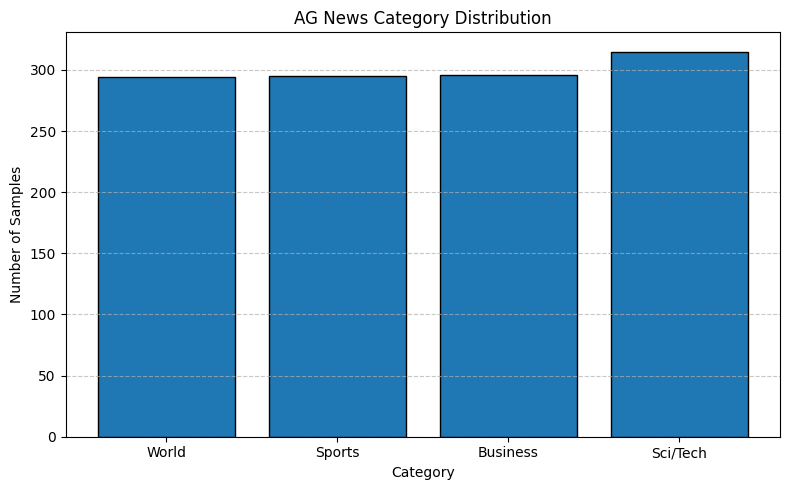

In [389]:
# Combine both for full distribution
df_all = pd.concat([df_train, df_test], ignore_index=True)

# Count number of samples per class
class_distribution = df_all['label'].value_counts().sort_index()
class_labels = ['World', 'Sports', 'Business', 'Sci/Tech']

# Plot the distribution
plt.figure(figsize=(8, 5))
plt.bar(class_labels, class_distribution, edgecolor='black')
plt.title("AG News Category Distribution")
plt.xlabel("Category")
plt.ylabel("Number of Samples")
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

#Bag of Words

Bag of Words is one of the simplest and most commonly used techniques to convert text into numerical features so that it can be fed into machine learning or deep learning models.

#How it Works:
Build a vocabulary of all the unique words in your dataset.
Represent each sentence (or document) as a vector.
Each position in the vector corresponds to a word in the vocabulary.
The value at each position is:


0 if the word is not in the sentence


1 or more based on how many times the word appears (i.e., word count)

In [390]:
# Convert Text to Numeric Features
vectorizer = CountVectorizer(max_features=5000, stop_words='english')
X_train = vectorizer.fit_transform(df_train['text']).toarray()
y_train = df_train['label'].values

In [391]:
# Show vocabulary
print("🔤 Vocabulary:")
print(vectorizer.vocabulary_)

# Show feature names (word order in vectors)
print("\n🧩 Feature Names (Columns):")
print(vectorizer.get_feature_names_out())

# Show sample text and its vector
print("\n📰 Sample Text:")
print(df_train['text'][0])

print("\n📊 Bag of Words Vector:")
print(X_train[0])


🔤 Vocabulary:
{'bangladesh': np.int64(361), 'paralysed': np.int64(3483), 'strikes': np.int64(4470), 'opposition': np.int64(3360), 'activists': np.int64(129), 'brought': np.int64(530), 'cities': np.int64(861), 'halt': np.int64(1892), 'day': np.int64(1288), '18': np.int64(30), 'people': np.int64(3572), 'died': np.int64(1385), 'political': np.int64(3715), 'rally': np.int64(3898), 'stability': np.int64(4405), 'redskins': np.int64(3945), 'coach': np.int64(931), 'joe': np.int64(2339), 'expects': np.int64(1608), 'major': np.int64(2770), 'personnel': np.int64(3590), 'changes': np.int64(771), 'offseason': np.int64(3318), 'wants': np.int64(4842), 'instill': np.int64(2175), 'culture': np.int64(1241), 'washington': np.int64(4854), 'putin': np.int64(3859), '39': np.int64(59), 'power': np.int64(3747), 'play': np.int64(3685), 'make': np.int64(2773), 'russia': np.int64(4114), 'safer': np.int64(4126), 'outwardly': np.int64(3415), 'changed': np.int64(770), 'terrorist': np.int64(4594), 'attacks': np.int6

In [392]:
X_test = vectorizer.transform(df_test['text']).toarray() # vectorize
y_test = df_test['label'].values

In [393]:
# Show feature names and encoded matrix
print("Vocabulary sample:", vectorizer.get_feature_names_out()[:10])
print("Train data shape:", X_train.shape)

Vocabulary sample: ['000' '04' '10' '100' '101' '106' '1066' '11' '112' '113']
Train data shape: (1000, 5000)


In [394]:
# PyTorch Dataset & DataLoader
class TextDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.y)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]


In [395]:
train_dataset = TextDataset(X_train, y_train)
test_dataset = TextDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [396]:
# Define MLP Model
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out = self.fc1(x)
        out = self.relu(out)
        out = self.fc2(out)
        return out

input_size = X_train.shape[1]
hidden_size = 128
output_size = 4
model = MLP(input_size, hidden_size, output_size)

In [397]:
# Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [398]:
# Train the Model
for epoch in range(100):
    model.train()
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
    print(f"Epoch {epoch+1}/5, Loss: {loss.item():.4f}")



Epoch 1/5, Loss: 1.3966
Epoch 2/5, Loss: 1.3942
Epoch 3/5, Loss: 1.3713
Epoch 4/5, Loss: 1.3865
Epoch 5/5, Loss: 1.3849
Epoch 6/5, Loss: 1.3774
Epoch 7/5, Loss: 1.3930
Epoch 8/5, Loss: 1.4020
Epoch 9/5, Loss: 1.3849
Epoch 10/5, Loss: 1.3879
Epoch 11/5, Loss: 1.3843
Epoch 12/5, Loss: 1.3771
Epoch 13/5, Loss: 1.3664
Epoch 14/5, Loss: 1.3834
Epoch 15/5, Loss: 1.3703
Epoch 16/5, Loss: 1.3889
Epoch 17/5, Loss: 1.3841
Epoch 18/5, Loss: 1.3771
Epoch 19/5, Loss: 1.3722
Epoch 20/5, Loss: 1.3719
Epoch 21/5, Loss: 1.3827
Epoch 22/5, Loss: 1.3671
Epoch 23/5, Loss: 1.3863
Epoch 24/5, Loss: 1.3777
Epoch 25/5, Loss: 1.3795
Epoch 26/5, Loss: 1.3869
Epoch 27/5, Loss: 1.3866
Epoch 28/5, Loss: 1.3816
Epoch 29/5, Loss: 1.3811
Epoch 30/5, Loss: 1.3821
Epoch 31/5, Loss: 1.3741
Epoch 32/5, Loss: 1.3852
Epoch 33/5, Loss: 1.3834
Epoch 34/5, Loss: 1.3625
Epoch 35/5, Loss: 1.3662
Epoch 36/5, Loss: 1.3763
Epoch 37/5, Loss: 1.3824
Epoch 38/5, Loss: 1.3672
Epoch 39/5, Loss: 1.3690
Epoch 40/5, Loss: 1.3687
Epoch 41/

In [399]:
# Evaluate the Model
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f"Test Accuracy: {100 * correct / total:.2f}%")



Test Accuracy: 30.00%


## CNN Model for Text Classification

In [400]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


In [401]:
class TextCNN(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_classes):
        super(TextCNN, self).__init__()
        self.embedding = nn.....(vocab_size, embed_dim)
        self.conv1 = nn.....(1, 100, (3, embed_dim))  # Kernel size (3, embed_dim)
        self.pool = nn.....(kernel_size=2)
        self.fc = nn.Linear(100, num_classes)

    def forward(self, x):
        x = self.embedding(x).unsqueeze(1)  # (batch, channel=1, seq_len, embed_dim)
        x = F.relu(self.conv1(x)).squeeze(3)  # (batch, out_channels, seq_len - kernel + 1)
        x = F.max_pool1d(x, x.size(2)).squeeze(2)
        return self.fc(x)


SyntaxError: invalid syntax (2848615674.py, line 4)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.......(outputs, dim=1)

            all_preds......(preds.cpu().numpy())
            all_labels.....(labels.cpu().numpy())

    # Metrics
    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"✅ Accuracy: {acc:.4f}")
    print("📋 Classification Report:\n", report)
    print("🔢 Confusion Matrix:\n", cm)


In [ ]:
evaluate(model, test_loader, device)


✅ Accuracy: 0.7250
📋 Classification Report:
               precision    recall  f1-score   support

           0     0.7778    0.5600    0.6512        50
           1     0.7846    0.9808    0.8718        52
           2     0.7200    0.6667    0.6923        54
           3     0.6122    0.6818    0.6452        44

    accuracy                         0.7250       200
   macro avg     0.7237    0.7223    0.7151       200
weighted avg     0.7275    0.7250    0.7183       200

🔢 Confusion Matrix:
 [[28  7  6  9]
 [ 1 51  0  0]
 [ 5  3 36 10]
 [ 2  4  8 30]]


##  LSTM Model for Text Classification

In [ ]:
class TextLSTM(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes):
        super(TextLSTM, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim)
        self.lstm = nn.........(embed_dim, hidden_dim, batch_first=True)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, x):
        x = self.embedding(x)
        _, (hidden, _) = self.lstm(x)
        return self.fc(hidden[-1])


In [ ]:
def evaluate(model, dataloader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    acc = accuracy_score(all_labels, all_preds)
    report = classification_report(all_labels, all_preds, digits=4)
    cm = confusion_matrix(all_labels, all_preds)

    print(f"✅ Accuracy: {acc:.4f}")
    print("📋 Classification Report:\n", report)
    print("🔢 Confusion Matrix:\n", cm)


In [ ]:
evaluate(model, test_loader, device)


✅ Accuracy: 0.7250
📋 Classification Report:
               precision    recall  f1-score   support

           0     0.7778    0.5600    0.6512        50
           1     0.7846    0.9808    0.8718        52
           2     0.7200    0.6667    0.6923        54
           3     0.6122    0.6818    0.6452        44

    accuracy                         0.7250       200
   macro avg     0.7237    0.7223    0.7151       200
weighted avg     0.7275    0.7250    0.7183       200

🔢 Confusion Matrix:
 [[28  7  6  9]
 [ 1 51  0  0]
 [ 5  3 36 10]
 [ 2  4  8 30]]
